Source code obtained from https://github.com/AustinLBuchanan/Districting-Examples/tree/main/starters
This code has been modified from Oklahoma to fit Idaho
Credit to Austin Buchanan

In [1]:
from gerrychain import Graph

In [2]:
# Read Idaho county graph from the json file "ID_county.json"
filename = 'ID_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filename )

In [3]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    population = G.nodes[node]['TOTPOP']
    x_coordinate = G.nodes[node]['C_X']
    y_coordinate = G.nodes[node]['C_Y']
    print("Node",node,"is",name,"County, which has population",population,"and is centered at (",x_coordinate,",",y_coordinate,")")

Node 0 is Lewis County, which has population 3821 and is centered at ( -116.42625178560918 , 46.23702314406699 )
Node 1 is Idaho County, which has population 16267 and is centered at ( -115.46745103298879 , 45.84419796794917 )
Node 2 is Camas County, which has population 1117 and is centered at ( -114.80585387535139 , 43.463250656373454 )
Node 3 is Power County, which has population 7817 and is centered at ( -112.84066960021103 , 42.693686655410794 )
Node 4 is Bear Lake County, which has population 5986 and is centered at ( -111.32965930452752 , 42.28477507282713 )
Node 5 is Latah County, which has population 37244 and is centered at ( -116.71167979837338 , 46.8161275012604 )
Node 6 is Washington County, which has population 10198 and is centered at ( -116.78477138496368 , 44.45242559517531 )
Node 7 is Canyon County, which has population 188923 and is centered at ( -116.70929246980863 , 43.62513350043343 )
Node 8 is Gem County, which has population 16719 and is centered at ( -116.39722

In [4]:
# pip install geopy

In [5]:
# what is the "distance" between Lewis County (node 0), Bonneville County (node 15), and Blaine County (node 23)?
from geopy.distance import geodesic

# Store centroid location as ( long, lat )
Lewis = ( G.nodes[0]['C_Y'],  G.nodes[0]['C_X'] )
Bonneville = ( G.nodes[15]['C_Y'], G.nodes[15]['C_X'] )
Blaine = ( G.nodes[23]['C_Y'], G.nodes[23]['C_X'] )

# Print the distance in miles
print("Lewis -> Bonneville:",geodesic(Lewis, Bonneville).miles)
print("Bonneville -> Blaine:",geodesic(Bonneville, Blaine).miles)
print("Blaine -> Lewis:",geodesic(Blaine, Lewis).miles)

Lewis -> Bonneville: 307.5313916730925
Bonneville -> Blaine: 119.05438495772937
Blaine -> Lewis: 229.09074212248242


In [6]:
# create distance dictionary
dist = dict()
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'],  G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'],  G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [7]:
# check the dictionary by printing the Lewis County -> Bonneville County distance
print("Lewis -> Bonneville:",dist[0,15])

Lewis -> Bonneville: 307.5313916730925


In [8]:
# Let's impose a population deviation ranging from 1% to 0.1% depending on user input.
deviation = 0.01

import math
k = 2          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 779873 and U = 787709 and k = 2


In [9]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create x[i,j] variable which equals one when county i 
#    is assigned to (the district centered at) county j
x = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY) 

Academic license - for non-commercial use only - expires 2021-05-31
Using license file C:\Users\lcrat\gurobi.lic


In [10]:
# objective is to minimize the moment of inertia: d^2 * p * x
m.setObjective( gp.quicksum( dist[i,j]*dist[i,j]*G.nodes[i]['TOTPOP']*x[i,j] for i in G.nodes for j in G.nodes), GRB.MINIMIZE )

In [11]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in G.nodes) == 1 for i in G.nodes)

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [12]:
# Add contiguity constraints
import networkx as nx
DG = nx.DiGraph(G) # directed version of G

# Add variable f[j,u,v] which equals the amount of flow (originally from j) that is sent across arc (u,v)
f = m.addVars( DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)
M = DG.number_of_nodes() - 1
# Add constraint saying that node j cannot receive flow of its own type
m.addConstrs( gp.quicksum( f[j,u,j] for u in DG.neighbors(j) ) == 0 for j in DG.nodes)
# Add constraints saying that node i can receive flow of type j only if i is assigned to j
m.addConstrs(gp.quicksum( f[j,u,i] for u in DG.neighbors(i) )<= M * x[i,j] for i in DG.nodes for j in DG.nodes if i != j )

# If i is assigned to j, then i should consume one unit of j flow. 
#    Otherwise, i should consume no units of j flow.
m.addConstrs( gp.quicksum( f[j,u,i] - f[j,i,u] for u in G.neighbors(i)) == x[i,j] for i in DG.nodes for j in DG.nodes if i != j )

m.update()

In [13]:
# solve, making sure to set a 0.00% MIP gap tolerance(!)
m.Params.MIPGap = 0.0
m.optimize()

Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5897 rows, 10912 columns and 39940 nonzeros
Model fingerprint: 0xf7d6446e
Variable types: 8976 continuous, 1936 integer (1936 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+06, 5e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 174 rows and 289 columns
Presolve time: 0.27s
Presolved: 5723 rows, 10623 columns, 39232 nonzeros
Variable types: 8687 continuous, 1936 integer (1936 binary)

Root relaxation: objective 2.199830e+10, 1230 iterations, 0.27 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth Int

In [14]:
print("The moment of inertia objective is",m.objval)

# retrieve the districts and their populations
centers = [j for j in G.nodes if x[j,j].x > 0.5 ]
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in centers]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The moment of inertia objective is 23580384795.87092
District 0 has population 787060 and contains counties ['Camas', 'Power', 'Bear Lake', 'Canyon', 'Caribou', 'Clark', 'Lemhi', 'Fremont', 'Twin Falls', 'Bonneville', 'Minidoka', 'Custer', 'Owyhee', 'Teton', 'Blaine', 'Jefferson', 'Gooding', 'Jerome', 'Elmore', 'Oneida', 'Lincoln', 'Cassia', 'Franklin', 'Butte', 'Madison', 'Bingham', 'Bannock']
District 1 has population 780522 and contains counties ['Lewis', 'Idaho', 'Latah', 'Washington', 'Gem', 'Bonner', 'Boundary', 'Boise', 'Payette', 'Nez Perce', 'Adams', 'Clearwater', 'Valley', 'Kootenai', 'Ada', 'Benewah', 'Shoshone']


In [15]:
# Let's draw it on a map
import geopandas as gpd

In [16]:
# Read Idaho county shapefile from "ID_counties.shp"
filename = 'ID_counties.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filename )

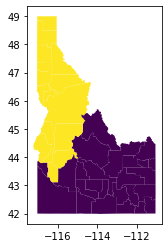

In [17]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()